<a href="https://colab.research.google.com/github/juliaviolet/BCCOptionsStrategies/blob/main/BCC_Options_Strategies_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The **Bakshi, Cao, and Chen** (BCC) options pricing model, introduced in 1997, is a significant extension of the Black-Scholes model. It incorporates stochastic volatility and "jumps" in the underlying asset price, aiming to address some of the limitations of the Black-Scholes model. This makes the BCC model more flexible and often more accurate for pricing options in the real world, where markets are not perfectly efficient, i.e. where asset prices can be highly volatile and subject to sudden jumps.

### **BCC Model Hedging Strategies:**

#### **1. Delta Hedging:**
Delta hedging involves buying or selling shares of the underlying asset to offset the delta of an options position. In the BCC model, delta is not constant but changes as the volatility and the underlying asset price change. Delta hedging in this context becomes a dynamic process, requiring frequent adjustments to the hedge ratio as the stochastic volatility and jumps affect the option’s delta.

#### **2. Vega Hedging:**
Vega measures the sensitivity of an option's price to changes in the volatility of the underlying asset. In the BCC model, volatility itself is stochastic, which means that vega hedging needs to account not just for changes in the current volatility, but also for the probability distribution of future volatilities. Vega hedging in the BCC context is more complex because it requires anticipating how the market will price changes in volatility, including sudden jumps, over the option's life.

#### **4. Theta Hedging:**

Theta measures the sensitivity of an option's price to the passage of time, often referred to as "time decay." In traditional options pricing models like Black-Scholes, theta is a relatively straightforward calculation. However, in the context of the BCC model, theta becomes far more complex. This complexity arises because the model incorporates stochastic volatility and price jumps, both of which can dramatically affect an option's value as time passes. Theta hedging, therefore, aims to offset the loss in an option's value due to time decay, while taking into account the stochastic nature of other parameters like volatility and asset price jumps. Given that these elements can change unexpectedly, maintaining a theta hedge requires frequent adjustments and can incur high transaction costs.

#### 3. **Gamma Hedging:**
Gamma is the rate of change of delta with respect to the underlying asset price. Gamma hedging aims to make an options position insensitive to changes in the asset price. In the BCC model, because both volatility and jumps in asset price are stochastic, the gamma of an option will also be a dynamic quantity. This makes gamma hedging more challenging because the hedging strategy has to be continuously updated to account for changes in these parameters.

**Setting Up the BCC Model and Utilities**

1. **Library Imports**: The cell starts by importing essential Python libraries:
    - `numpy` for numerical operations
    - `pandas` for data manipulation
    - `numba` for optimizing numerical computations
    - `scipy.integrate` and `scipy.optimize` for numerical integration and optimization tasks

2. **Characteristic Functions**: Four functions are defined to compute the characteristic functions of different models that are components of the BCC model:
    - `CIR_char_func`: Computes the characteristic function for the Cox-Ingersoll-Ross (CIR) model for interest rates.
    - `H93_char_func`: Computes the characteristic function for the Heston '93 model, which deals with stochastic volatility.
    - `M76_char_func`: Computes the characteristic function for the Merton '76 model, which includes jump diffusion.
    - `BCC_char_func`: Computes the characteristic function for the BCC model, incorporating aspects of the above models, including stochastic volatility and jump diffusion.

These functions compute mathematical entities used in Fourier transform methods for options pricing. The `@njit` decorator optimizes these functions using JIT compilation.

3. **Numerical Integration and Option Pricing**:
    - `BCC_int_func`: This function performs numerical integration of the BCC characteristic function.
    - `BCC_call_value`: Computes the price of a call option using the BCC model.

Functions for numerical integration and option pricing use the characteristic functions to ultimately compute the price of call options using the BCC model.

4. **Data Preparation and Time to Maturity**:
    - The cell reads `sorted_options_data.csv` and separates underlying asset and options data.
    - A new column `T` is added to represent time to maturity for each option.

5. **Optimization Setup**:
    - `objective`: Defines an objective function that computes the sum of squared differences between the market and model prices.
    - Initial parameters and bounds for the optimization are also specified.

6. **Pricing and Data Export**:
    - The model prices of options based on initial parameters are calculated and added to a new column `MODEL_PRICE`.
    - Market prices for call and put options are calculated and stored in `MARKET_PRICE`.
    - The resulting data frame is exported to a CSV file named `simply_optimal_options_data.csv`.

This initial code lays the foundation for the subsequent analysis, importing necessary modules, defining key functions, and preparing the data.



In [ ]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.integrate import quad
from scipy.optimize import minimize

#Defining the required functions for the M76, H93, BCC model
# Valuation of European Call and Put Options
# Under Stochastic Volatility and Jumps
# 09_gmm/BCC_option_valuation.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python

#characteristic function of the CIR model for interest rates.

@njit
def CIR_char_func(u, T, kappa, theta, sigma_r, r0):
    gamma = np.sqrt(kappa**2 + 2*sigma_r**2*u*1j)
    A = 2*gamma*np.exp((kappa+gamma)*T/2) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    B = 2*(np.exp(gamma*T)-1) / (2*gamma+(gamma+kappa)*(np.exp(gamma*T)-1))
    char_func_value = np.exp(A*theta-B*r0)
    return char_func_value

#Heston '93 characteristic function
@njit
def H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt((rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v ** 2 * (-u * 1j - u ** 2))
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (kappa_v - rho * sigma_v * u * 1j - c2)
    H1 = (r0 * u * 1j * T + (c1 / sigma_v ** 2) * ((kappa_v - rho * sigma_v * u * 1j + c2) * T - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))))
    H2 = ((kappa_v - rho * sigma_v * u * 1j + c2) / sigma_v ** 2 * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T))))
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

#Merton '76 characteristic function, jump diffusion
@njit
def M76_char_func(u, T, lamb, mu, delta):
    omega = -lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    char_func_value = np.exp((1j * u * omega + lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return char_func_value

#Bakshi, Cao and Chen '97 characteristic function, jump diffusion + stochastic volatility
@njit
def BCC_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    CIR1 = CIR_char_func(u, T, kappa, theta, sigma_r, r0)
    BCC1 = H93_char_func(u, T, r0, kappa_v, theta_v, sigma_v, rho, v0)
    BCC2 = M76_char_func(u, T, lamb, mu, delta)
    jumpVolatilityPart = lamb * (np.exp(1j * u * muV * deltaV) - 1) * T
    return CIR1 * BCC1 * BCC2 * np.exp(jumpVolatilityPart * rhoJ)

#numerical integration of BCC_char_func
@njit
def BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    char_func_value = BCC_char_func(u - 1j * 0.5, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ)
    int_func_value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    return int_func_value

#call option price calculation using the BCC model
def BCC_call_value(S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ):
    int_value = quad(lambda u: BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
    call_value = max(0, S0 - np.exp(-r0 * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

# Read the data
file_path = 'sorted_options_data.csv'
options_data = pd.read_csv(file_path)

# Separate the underlying and option data
underlying_data = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the time to maturity for each option
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Reset the indices
options_data = options_data.reset_index(drop=True)

# Initial interest rate
r0 = -0.00067

# Define the objective function to accommodate the stochastic interest rate
def objective(params, option_type, options_data):
    kappa, theta, sigma_r, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, muV, deltaV, rhoJ = params
    sum_squared_errors = 0
    for idx, row in options_data.iterrows():
        if row['PUTCALLIND'] == option_type:
            model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                         kappa=kappa, theta=theta, sigma_r=sigma_r, r0=r0,
                                         kappa_v=kappa_v, theta_v=theta_v, sigma_v=sigma_v, rho=rho, v0=v0,
                                         lamb=lamb, mu=mu, delta=delta, muV=muV, deltaV=deltaV, rhoJ=rhoJ)
            market_price = np.maximum(row['CF_CLOSE'] - row['STRIKE_PRC'], 0) if option_type == 'CALL' else np.maximum(row['STRIKE_PRC'] - row['CF_CLOSE'], 0)
            sum_squared_errors += (model_price - market_price) ** 2
    return sum_squared_errors

# Define the initial parameters
initial_params = [3.76807610e+00, 1.00000000e-03, 8.77986615e-03, 5.67355018e-03,
 4.16586532e+00, 2.29651712e-03, 1.14133804e-02, 5.03063522e-01,
 0.00000000e+00, 3.95979221e-01, 7.10854746e-02, 4.01539560e-02,
 6.99623759e-02, 9.99763692e-02, 5.00002718e-01]

# Bounds for the parameters
bounds = [(0.1, 10),    # kappa
    (0.001, 0.03), # theta
    (0.001, 0.03), # sigma_r
    (-0.01, 0.01), # r0
    (0.1, 10),    # kappa_v
    (0.001, 0.03), # theta_v
    (0.001, 0.03), # sigma_v
    (-1, 1),      # rho
    (0, 0.1),     # v0
    (0, 2),       # lamb
    (-1, 1),      # mu
    (0, 1),       # delta
    (-1, 1),      # muV
    (0, 1),       # deltaV
    (-1, 1)       # rhoJ
]

# Selecting options in a specific range for demonstration
options_in_range = options_data.copy()

# Price the options using the initial parameters
for idx, row in options_in_range.iterrows():
    if row['PUTCALLIND'] == 'CALL':
        model_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'],
                                     r0=initial_params[3], kappa_v=initial_params[4], theta_v=initial_params[5],
                                     sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                     lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11],
                                     kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2],
                                     muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14])
    else:
        call_price = BCC_call_value(S0=row['CF_CLOSE'], K=row['STRIKE_PRC'], T=row['T'], r0=initial_params[3],
                                    kappa=initial_params[0], theta=initial_params[1], sigma_r=initial_params[2],
                                    kappa_v=initial_params[4], theta_v=initial_params[5], sigma_v=initial_params[6], rho=initial_params[7], v0=initial_params[8],
                                    lamb=initial_params[9], mu=initial_params[10], delta=initial_params[11], muV=initial_params[12], deltaV=initial_params[13], rhoJ=initial_params[14])
        model_price = call_price + row['STRIKE_PRC']*np.exp(-r0*row['T']) - row['CF_CLOSE']

    options_in_range.loc[idx, 'MODEL_PRICE'] = model_price

options_in_range

# Calculate the market price for both call and put options
options_in_range['MARKET_PRICE'] = 0
options_in_range.loc[options_in_range['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_in_range.loc[options_in_range['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_in_range.loc[options_in_range['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_in_range.loc[options_in_range['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Print the options data with model prices and market prices
print(options_in_range)
data = options_in_range
data.to_csv('simply_optimal_options_data.csv', index=False)

<ipython-input-2-7be554d71811>:61: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_value = quad(lambda u: BCC_int_func(u, S0, K, T, r0, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta, kappa, theta, sigma_r, muV, deltaV, rhoJ), 0, np.inf, limit=250)[0]
<ipython-input-2-7be554d71811>:61: IntegrationWarning: The maximum number of subdivisions (250) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, disconti

     Unnamed: 0        Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0           233  /GDAX118000F0.EX  2020-05-15  2020-06-19       CALL   
1           231  /GDAX117500F0.EX  2020-05-15  2020-06-19       CALL   
2           235  /GDAX118500F0.EX  2020-05-14  2020-06-19       CALL   
3           237  /GDAX119000F0.EX  2020-05-14  2020-06-19       CALL   
4           229  /GDAX117000F0.EX  2020-05-15  2020-06-19       CALL   
..          ...               ...         ...         ...        ...   
373           7   /GDAX41000F0.EX  2020-05-15  2020-06-19       CALL   
374           5   /GDAX40000F0.EX  2020-03-09  2020-06-19       CALL   
375           3   /GDAX36000F0.EX  2020-03-17  2020-06-19       CALL   
376           2   /GDAX20000R0.EX  2020-04-30  2020-06-19       PUT    
377           1   /GDAX20000F0.EX  2020-05-15  2020-06-19       CALL   

     STRIKE_PRC  CF_CLOSE  IMP_VOLT         T  MODEL_PRICE  MARKET_PRICE  
0       11800.0      12.2     23.22  0.095825     0.000000  

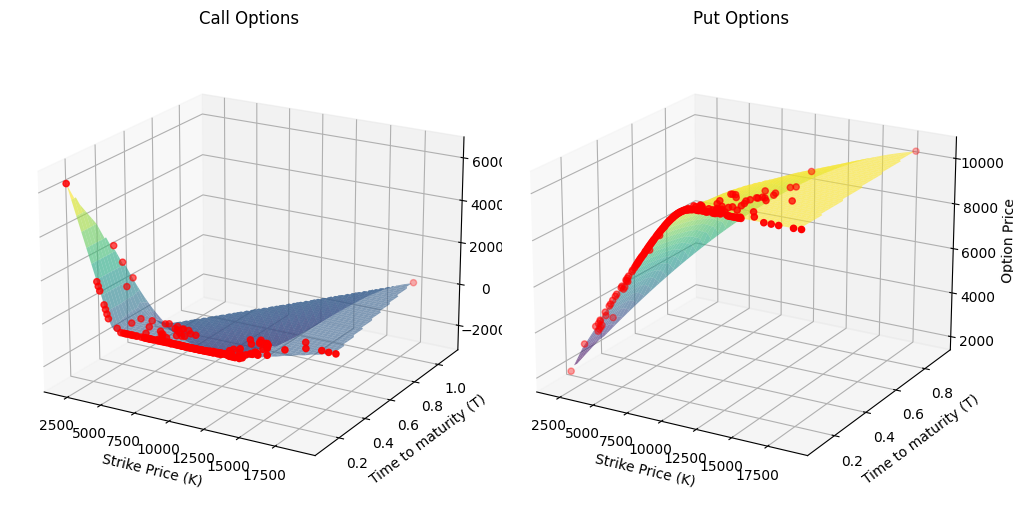

In [ ]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import griddata

# Read the data
file_path = 'simply_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Calculate time to expiration
options_data['T'] = (pd.to_datetime(options_data['EXPIR_DATE']) - pd.to_datetime(options_data['CF_DATE'])).dt.days / 365.25

# Calculate the market price for both call and put options
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Separate the data into call and put options
call_options = options_data[options_data['PUTCALLIND'] == 'CALL']
put_options = options_data[options_data['PUTCALLIND'] == 'PUT ']

# Define the variables for Strike Prices and Time to Maturity for calls and puts
K_call, T_call = call_options['STRIKE_PRC'].values, call_options['T'].values
K_put, T_put = put_options['STRIKE_PRC'].values, put_options['T'].values

# Create a mesh grid for T and K for calls and puts
K_grid_call, T_grid_call = np.meshgrid(np.linspace(min(K_call), max(K_call), 100), np.linspace(min(T_call), max(T_call), 100))
K_grid_put, T_grid_put = np.meshgrid(np.linspace(min(K_put), max(K_put), 100), np.linspace(min(T_put), max(T_put), 100))

# Create a new figure
fig = plt.figure(figsize=(10, 6))

# Create 3D plots for call options
ax1 = fig.add_subplot(121, projection='3d')
model_price_grid_call = griddata((K_call, T_call), call_options['MODEL_PRICE'], (K_grid_call, T_grid_call), method='cubic')
ax1.plot_surface(K_grid_call, T_grid_call, model_price_grid_call, cmap='viridis', alpha=0.6)
ax1.scatter(K_call, T_call, call_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax1.set_title('Call Options')
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to maturity (T)')
ax1.set_zlabel('Option Price', rotation=90)
ax1.view_init(20, -60)  # Adjust the viewing angle for better visualization

# Create 3D plots for put options
ax2 = fig.add_subplot(122, projection='3d')
model_price_grid_put = griddata((K_put, T_put), put_options['MODEL_PRICE'], (K_grid_put, T_grid_put), method='cubic')
ax2.plot_surface(K_grid_put, T_grid_put, model_price_grid_put, cmap='viridis', alpha=0.6)
ax2.scatter(K_put, T_put, put_options['MARKET_PRICE'], color='r', marker='o', s=20)
ax2.set_title('Put Options')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to maturity (T)')
ax2.set_zlabel('Option Price', rotation=90)
ax2.view_init(20, -60)  # Adjust the viewing angle for better visualization

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# Read the data
file_path = 'simply_optimal_options_data.csv'
options_data = pd.read_csv(file_path)

# Skip the underlying asset info
underlying_asset = options_data.iloc[0]
options_data = options_data.iloc[1:]

# Calculate the market price for each option
options_data['MARKET_PRICE'] = 0
options_data.loc[options_data['PUTCALLIND'] == 'CALL', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'CALL'].apply(lambda row: max(row['CF_CLOSE'] - row['STRIKE_PRC'], 0), axis=1)
options_data.loc[options_data['PUTCALLIND'] == 'PUT ', 'MARKET_PRICE'] = options_data.loc[options_data['PUTCALLIND'] == 'PUT '].apply(lambda row: max(row['STRIKE_PRC'] - row['CF_CLOSE'], 0), axis=1)

# Calculate the percentage error between the model and market prices
options_data['PERCENTAGE_ERROR'] = abs((options_data['MODEL_PRICE'] - options_data['MARKET_PRICE']) / options_data['MARKET_PRICE'] * 100)

# Correct infinite percentage errors due to division by zero
options_data.loc[options_data['PERCENTAGE_ERROR'] == float('inf'), 'PERCENTAGE_ERROR'] = None

# Define a threshold for what you consider a "reasonable" error
threshold = 5.0

# Add a new column indicating if the percentage error is outside the threshold
options_data['OUTSIDE_THRESHOLD'] = options_data['PERCENTAGE_ERROR'] > threshold

# Create a new column combining option type and threshold status
options_data['OPTION_STATUS'] = options_data.apply(lambda row: row['PUTCALLIND'].strip() + (' Outside' if row['OUTSIDE_THRESHOLD'] else ' Inside'), axis=1)

# Extract relevant columns
result = options_data[['OPTION_STATUS', 'IMP_VOLT', 'PERCENTAGE_ERROR', 'MODEL_PRICE']]

# Create a scatter plot with facets
fig = px.scatter(result,
                 x='MODEL_PRICE',
                 y='IMP_VOLT',
                 color='PERCENTAGE_ERROR',
                 facet_col='OPTION_STATUS',
                 title='Option Prices vs. Implied Volatility',
                 labels={'MODEL_PRICE': 'Option Price', 'IMP_VOLT': 'Implied Volatility', 'OPTION_STATUS': 'Option Type & Status'},
                 color_continuous_scale='viridis',
                 hover_data=['OPTION_STATUS', 'PERCENTAGE_ERROR'])

# Modify the marker aesthetics
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Update facet titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

# Show the plot
fig.show()


The underlying asset data is sorted to implement the hedging strategies.


In [ ]:
#underlying asset price at market close from MarketWatch https://www.marketwatch.com/investing/index/dax/download-data?startDate=05/15/2019&endDate=05/15/2020&countryCode=dx

# Import the data
file_path = 'updated_merged_data_fixed.csv'
updated_merged_data_fixed = pd.read_csv(file_path)

# Skip the first row and sort the rest by 'CF_DATE' in ascending order
sorted_data = updated_merged_data_fixed.iloc[1:].sort_values(by='CF_DATE', ascending=True)

# Output the sorted DataFrame to a new CSV file
sorted_file_path = 'sorted_updated_merged_data_fixed.csv'
sorted_data.to_csv(sorted_file_path, index=False)

sorted_file_path

'sorted_updated_merged_data_fixed.csv'